# Legal Eval 2023: subtask A

This notebook is concerned on LegalEval task solution during SemEval 2023. Main repository can be found [here](https://github.com/aassegai/LegalEval23).



### Task overview
Given that legal documents are long and unstructured, we propose a task for automatically segmenting legal judgment documents into semantically coherent text segments, and each such segment is assigned a label such as a preamble, fact, ratio, arguments, etc. These are referred to as Rhetorical Roles. The task was to sequentially classify the segments of the long legal texts. More informarion is available [here.](https://github.com/Legal-NLP-EkStep/rhetorical-role-baseline)

In [28]:
'''
Sometimes when GPU runtime is used an error appears
NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968
This piece of code fixes this problem.
'''
import locale
if str(locale.getpreferredencoding()) != 'UTF-8':
    def getpreferredencoding(do_setlocale = True):
      return "UTF-8"
    locale.getpreferredencoding = getpreferredencoding

## Git Stuff


In [3]:
! git clone https://github.com/aassegai/LegalEval23
import os
os.chdir('LegalEval23')

Cloning into 'LegalEval23'...
remote: Enumerating objects: 464, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 464 (delta 80), reused 158 (delta 51), pack-reused 257
Receiving objects: 100% (464/464), 3.47 MiB | 19.84 MiB/s, done.
Resolving deltas: 100% (184/184), done.


## imports

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.cuda import empty_cache

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader

from tqdm.auto import tqdm 
import pickle

import seaborn as sns 
import matplotlib.pyplot as plt

! pip install nltk
! pip install evaluate
! pip install accelerate transformers==4.28.0
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re

import gc

! pip install transformers==4.28.0
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          BatchEncoding,
                          BertModel,
                          TrainingArguments,
                          Trainer)

import evaluate
from accelerate import find_executable_batch_size


import json
import re
import random
import os

from datasets import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.0 MB/s eta 0:0

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
legal_bert_name = "nlpaueb/legal-bert-base-uncased"
indian_legal_uncased_bert_name = 'law-ai/InLegalBERT'

## data preparation

### Downloading

In [8]:
raw_train_df = pd.read_json('./data/raw/train.json', encoding='utf-8')
raw_test_df = pd.read_json('./data/raw/dev.json', encoding='utf-8')

In [9]:
label2id = {'NONE': 0,
            'PREAMBLE': 1,
            'FAC': 2,
            'RLC': 3,
            'ISSUE': 4,
            'ARG_PETITIONER': 5,
            'ARG_RESPONDENT': 6,
            'ANALYSIS': 7,
            'STA': 8,
            'PRE_RELIED': 9,
            'PRE_NOT_RELIED': 10,
            'RATIO': 11,
            'RPC': 12
}

id2label = {1: 'PREAMBLE',
            2: 'FAC',
            3: 'RLC',
            4: 'ISSUE',
            5: 'ARG_PETITIONER',
            6: 'ARG_RESPONDENT',
            7: 'ANALYSIS',
            8: 'STA',
            9: 'PRE_RELIED',
            10: 'PRE_NOT_RELIED',
            11: 'RATIO',
            12: 'RPC',
            0: 'NONE'
}


num_labels = 13
max_seq_len = 512

### Preprocessing

Very important part of NLP tasks solution is the raw data preprocessing and filtering. It depends on a task type, model used and other factors. 

Let's look on the texts condition and see what should we do.

In [10]:
raw_train_df.loc[0].data['text'][:200]

"      IN THE HIGH COURT OF KARNATAKA,\n          CIRCUIT BENCH AT GULBARGA\n\nDATED THIS THE 22ND DAY OF FEBRUARY, 2013\n\n      BEFORE\n\nTHE HON'BLE MR.JUSTICE ANAND BYRAREDDY\n\n      CRIMINAL APPEAL NO.353"

In this case we obviously should remove technical symbols like */n* and unnecessary spaces litter, possibly lower-case the text and remove punctuation. 

In [11]:
from src.preprocessing.data_preprocessing import DataPreprocessor, ContextExtractor

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
train_data_preprocessor = DataPreprocessor(lower=True)
test_data_preprocessor = DataPreprocessor(lower=True)
train_df = train_data_preprocessor(raw_train_df)
test_df = test_data_preprocessor(raw_test_df)

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
train_df.head()

,annotations,data,meta
id,,,
1735,"[{'id': 'd7a902fe9c23417499a7ef782f9fbdeb', 's...","in the high court of karnataka, circuit bench ...",{'group': 'Criminal'}
4183,"[{'id': 'ac4523a0252e4007986cefbd6d5f571a', 's...","1/11 in the high court of karnataka, bengaluru...",{'group': 'Tax'}
4207,"[{'id': '43499bd62ea94624b2f38f4cbc677913', 's...",in the high court of karnataka circuit bench a...,{'group': 'Criminal'}
4097,"[{'id': 'ec5e65782b1949e4a5445a2115ab5382', 's...",petitioner: raghubar mandal harihar mandal vs....,{'group': 'Tax'}
1778,"[{'id': '7323f9247fbc4618bf006ef103d7cb3a', 's...",petitioner: p.k. badiani vs. respondent: the c...,{'group': 'Tax'}


The task organizers said that the segment context contains useful information for the classification process because the classes of the previous segments are important for labling the current segment. It also seems to be relevant because many sentences are semantically similar and we need additional information about the text structure. 

In [111]:
context_extractor = ContextExtractor()

In [112]:
train_df = context_extractor(train_df)
test_df = context_extractor(test_df, for_test=True)
test_labels = test_df['label'].apply(lambda x: label2id[x]).to_list()

Extracting context...


  0%|          | 0/244 [00:00<?, ?it/s]

Extracting context...


  0%|          | 0/30 [00:00<?, ?it/s]

In [113]:
train_df.head()

,doc_id,text,context,sentence,label
0,1735,"in the high court of karnataka, circuit bench ...","in the high court of karnataka, circuit bench ...","in the high court of karnataka, circuit bench ...",PREAMBLE
1,1735,"in the high court of karnataka, circuit bench ...","in the high court of karnataka, circuit bench ...",before the hon'ble mr.justice anand byrareddy ...,PREAMBLE
2,1735,"in the high court of karnataka, circuit bench ...","in the high court of karnataka, circuit bench ...",this criminal appeal is filed under section 37...,PREAMBLE
3,1735,"in the high court of karnataka, circuit bench ...","in the high court of karnataka, circuit bench ...","this appeal coming on for hearing this day, th...",PREAMBLE
4,1735,"in the high court of karnataka, circuit bench ...","in the high court of karnataka, circuit bench ...",heard the learned counsel for the appellant an...,NONE


### Data exploration

Let's see some data stats. First we will look at the sentence lengths.

<Axes: ylabel='Count'>

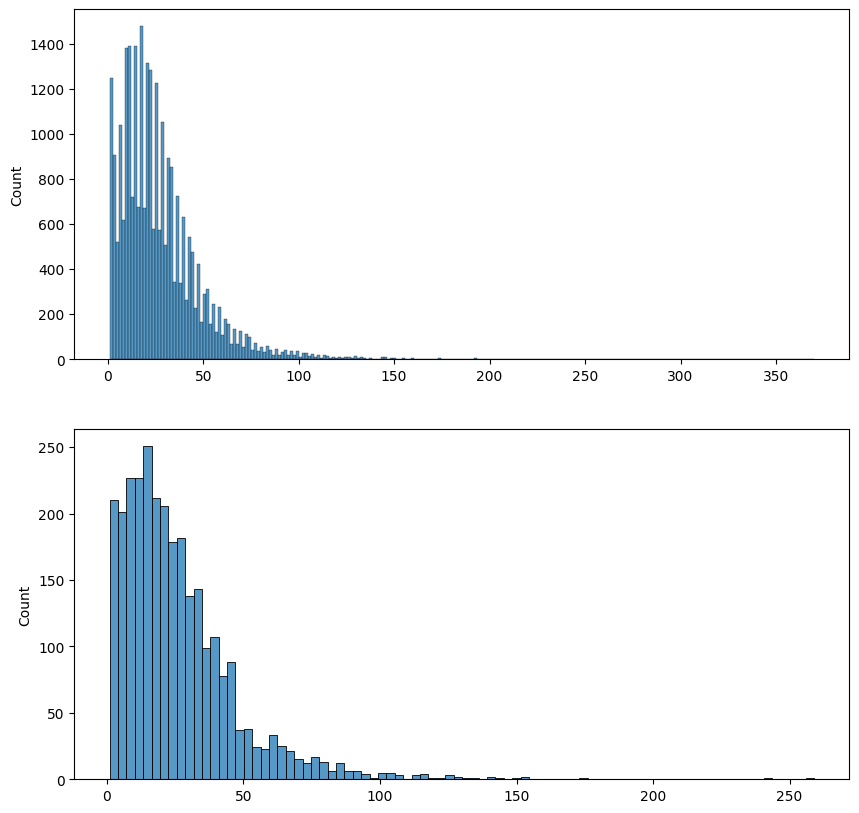

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.histplot(data=[len(sentence.split()) for sentence in train_df.sentence], ax=ax[0])
sns.histplot(data=[len(sentence.split()) for sentence in test_df.sentence], ax=ax[1])

Good thing here. No outliers and almost the same distribution in train and test datasets. What about unique words in the sentence? It is possible that some sentences (or a whole document) will consist of one symbol (like '............' or '___' etc.)

<Axes: ylabel='Count'>

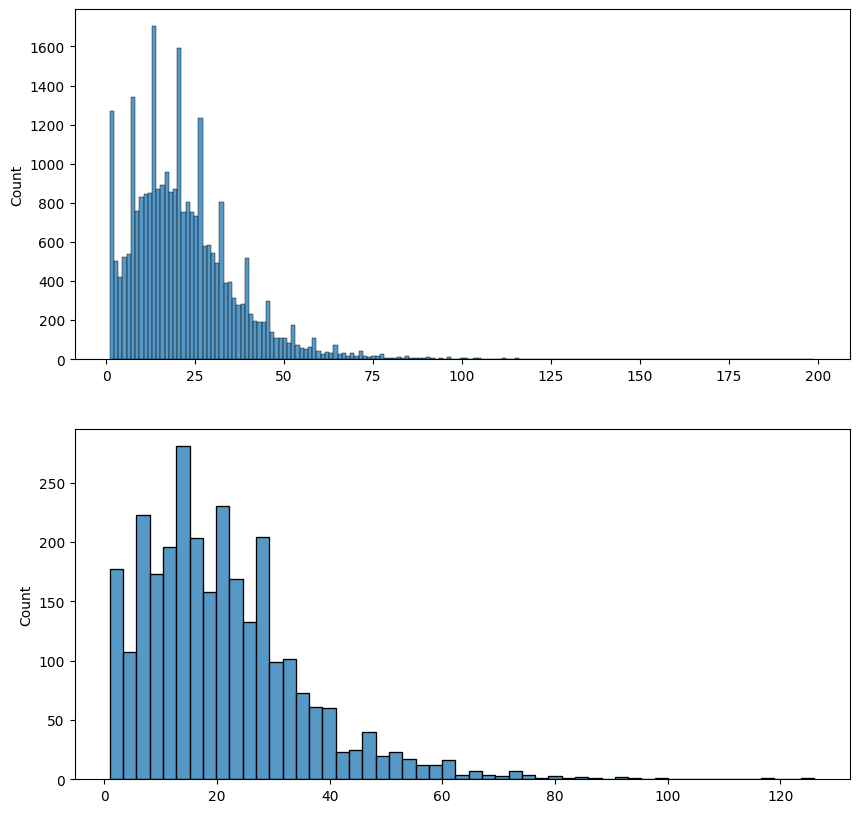

In [115]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
sns.histplot(data=[len(set(sentence.split())) for sentence in train_df.sentence], ax=ax[0])
sns.histplot(data=[len(set(sentence.split())) for sentence in test_df.sentence], ax=ax[1])

Same situation, no too short sentences, no too long. Great for us.

In [116]:
from utils import aggregate_label_stats, display_label_counts


Let's see some label stats.

In [117]:
aggregate_label_stats(train_df)

,label,count,mean_sentence_len,max_sentence_len,mean_context_len
0,ANALYSIS,10417,29.356917,306,481.580397
1,ARG_PETITIONER,1231,33.213647,217,477.790414
2,ARG_RESPONDENT,674,32.516320,215,478.485163
3,FAC,5635,25.979237,335,485.030524
4,ISSUE,364,36.607143,195,474.431319
5,NONE,1364,12.680352,263,498.243402
6,PREAMBLE,3871,19.291139,261,492.294498
7,PRE_NOT_RELIED,156,38.782051,150,472.217949
8,PRE_RELIED,1331,37.658903,250,473.343351
9,RATIO,660,32.609091,144,478.392424


In [118]:
aggregate_label_stats(test_df)

,label,count,mean_sentence_len,max_sentence_len,mean_context_len
0,ANALYSIS,984,28.641260,259,482.102642
1,ARG_PETITIONER,70,32.685714,103,478.414286
2,ARG_RESPONDENT,38,30.184211,92,480.842105
3,FAC,580,25.463793,153,485.636207
4,ISSUE,50,31.980000,126,479.020000
5,NONE,190,11.989474,95,499.110526
6,PREAMBLE,508,20.679134,131,490.933071
7,PRE_NOT_RELIED,12,43.083333,68,467.916667
8,PRE_RELIED,142,35.661972,115,475.338028
9,RATIO,70,28.971429,107,482.057143


We can see that mean context length is close to the max possible sequence length. As for sentences it is noticeably that STA class is usually almost twice longer than other classes.

The plots below are the label frequency distribution. Two news here: one good and one bad. The good thing is that train and test distributions are similar, the bad is that some classes (like 'STA' or 'PRE_NOT_RELIED') are extremely rare that can lead to unsatisfactory classification.

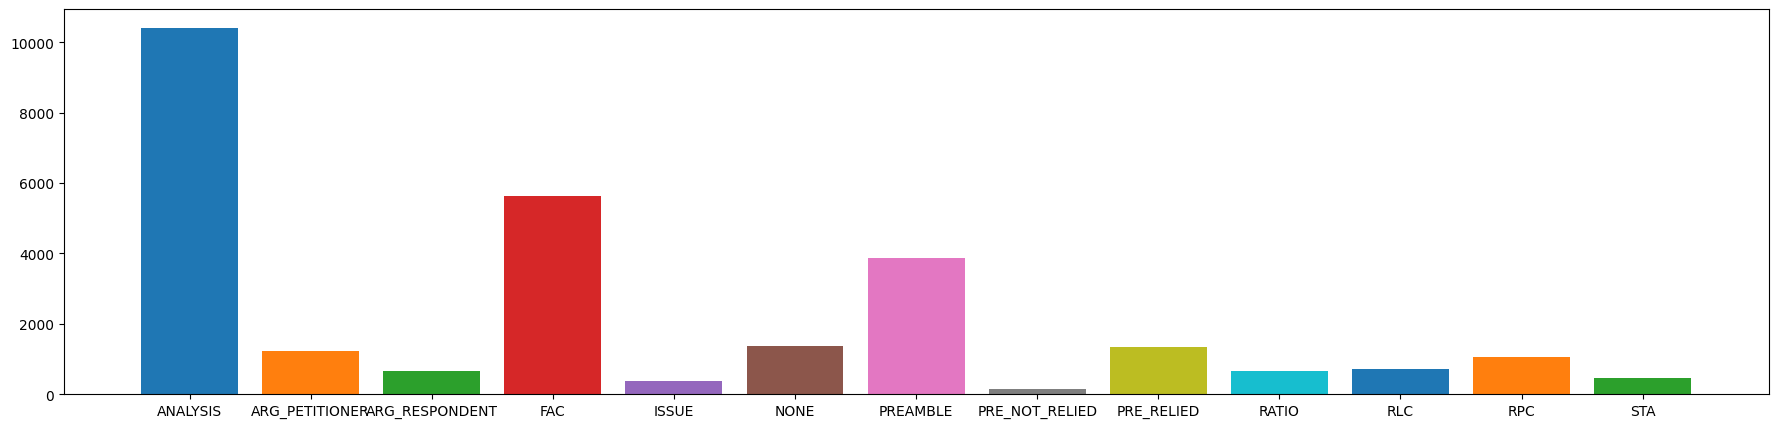

In [119]:
display_label_counts(train_df)

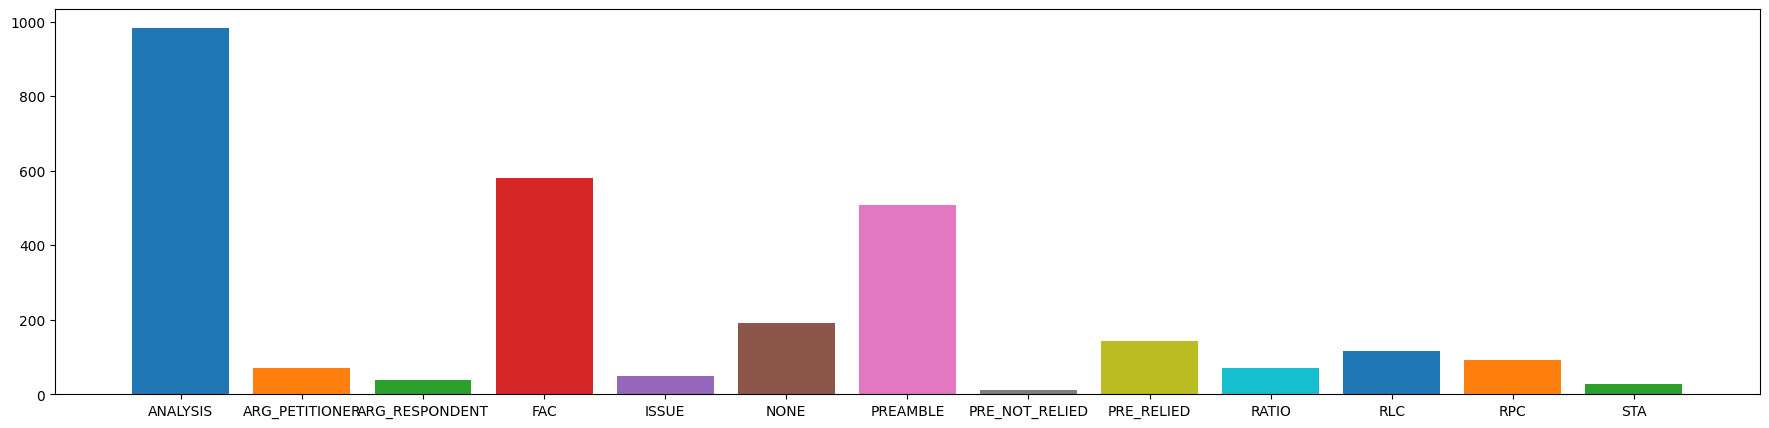

In [120]:
display_label_counts(test_df)

### Train-val split

Since we are using sentence context during the training process it is important to split the data so that there is no single text from the train set in the test set because in this case context from the train set will appear in validation set. 

In [121]:
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(n_splits=1, test_size=.15)  
train_idx, val_idx = next(splitter.split(train_df, groups=train_df['text']))
val_df = train_df.iloc[val_idx]
train_df = train_df.iloc[train_idx]

In [122]:
from src.datasets.dataset_builder import DatasetBuilder
builder = DatasetBuilder(indian_legal_uncased_bert_name)

In [123]:
train_dataset = builder.build_dataset(train_df)
val_dataset = builder.build_dataset(val_df)
test_dataset = builder.build_dataset(test_df, for_test=True)

Building dataset...


Map:   0%|          | 0/23571 [00:00<?, ? examples/s]

Building dataset...


Map:   0%|          | 0/4379 [00:00<?, ? examples/s]

Building dataset...


Map:   0%|          | 0/2879 [00:00<?, ? examples/s]

Map:   0%|          | 0/2879 [00:00<?, ? examples/s]

# Model

The best performing solution became the [law-ai/InLegalBERT](https://huggingface.co/law-ai/InLegalBERT) -- uncased BERT model pretrained on indian legal texts. It is finetuned with context along with the sentence to make the model know about the sentence semantic environment.

Hyperparameters chosen are:
* batch_size 32
* 3 training epochs
* 2e-5 learning rate
* 0.01 weight decay
* 0.15 label smoothing

The controversial question is do half-precision calculations or not? In this case prediction quality does not fall but training time drastically increases.

In [33]:
from src.model.transformer_trainer import TransformerTrainer
trainer_params = {'batch_size': 32,
                  'n_epochs': 3,
                  'lr': 2e-5,
                  'optimizer': 'adamw_torch',
                  'weight_decay': 0.01,
                  'do_fp16': True,
                  'num_workers': 2}

In [34]:
# cleaning cache to avoid out of memory errors
! rm -rf ./root/.cache/huggingface/hub/model*
empty_cache()
gc.collect()

26

In [35]:
TFTrainer = TransformerTrainer(bert_name=indian_legal_uncased_bert_name, 
                                num_labels=num_labels,
                                params=trainer_params,
                                id2label=id2label,
                                label2id=label2id)

In [36]:
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda:0')

In [37]:
trainer = TFTrainer.fit(train_dataset, 
            val_dataset,
            save_model=False)

Loading : law-ai/InLegalBERT


Some weights of the model checkpoint at law-ai/InLegalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initial

Epoch,Training Loss,Validation Loss,Precison,Recall,Weighted F1
1,1.101700,1.241137,0.774440,0.781135,0.773703
2,0.962200,1.246347,0.777827,0.784363,0.778350
3,0.969300,1.246347,0.777827,0.784363,0.778350


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetric

# evaluation


In this chapter we will predict labels for the dev set given and analyse the results.

In [124]:
test_logits = TFTrainer.predict(test_dataset, trainer)
test_preds = [np.argmax(logit) for logit in test_logits]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
print(classification_report(test_labels, test_preds, target_names=label2id.keys()))

                precision    recall  f1-score   support

          NONE       0.94      0.90      0.92       190
      PREAMBLE       0.97      1.00      0.99       508
           FAC       0.81      0.89      0.85       580
           RLC       0.64      0.42      0.51       116
         ISSUE       0.75      0.80      0.78        50
ARG_PETITIONER       0.42      0.33      0.37        70
ARG_RESPONDENT       0.39      0.74      0.51        38
      ANALYSIS       0.82      0.87      0.85       984
           STA       0.59      0.61      0.60        28
    PRE_RELIED       0.81      0.58      0.68       142
PRE_NOT_RELIED       0.00      0.00      0.00        12
         RATIO       0.82      0.26      0.39        70
           RPC       0.91      0.93      0.92        91

      accuracy                           0.83      2879
     macro avg       0.68      0.64      0.64      2879
  weighted avg       0.83      0.83      0.82      2879



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model does almost 100% perfect on NONE and PREAMBLE classes. It could be expected because PREAMBLE is always at the start of the document and has some standartized substring differing only by names and places. Also FAC, ANALYSIS and RPC have pretty high F1-score.

However, it can be seen that the smallest class 'PRE_NOT_RELIED' is always miss-classified because of very rare appearance in data. Also RATIO class has low rate of true answers. As for RATIO, model confuses it with ANALYSIS and it probably happens because this class often concludes ANALYSIS. 

Also model often mixes up ARG_PETITIONER and ARG_RESPONDENT. That should be happening because on some at some level of abstraction these are both arguments differing only by a party in court. 

It has to be said that ANALYSIS class brings serious confusion into the model behaviour because it is at least twice bigger than the second biggest class in the dataset.

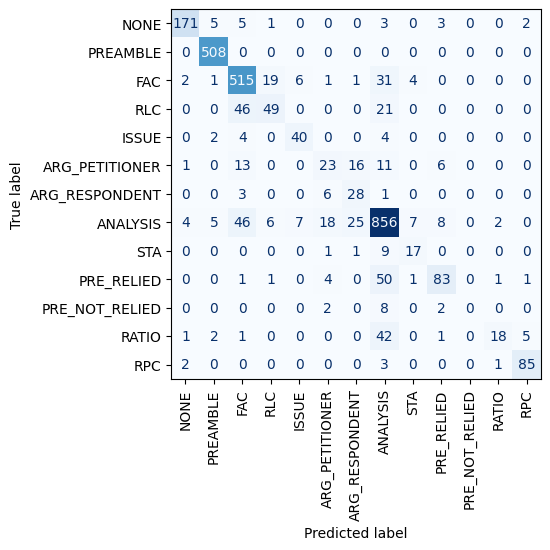

In [126]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, test_preds)
cmd = ConfusionMatrixDisplay(cm, display_labels=label2id.keys())
cmd.plot(cmap=plt.cm.Blues, xticks_rotation=90, colorbar=False)

In [150]:
from utils import show_text_segmentation
raw_test_df = pd.read_json('./data/raw/dev.json', encoding='utf-8')
display_dp = DataPreprocessor()
disp_test_df = display_dp(raw_test_df)
disp_test_df

  0%|          | 0/30 [00:00<?, ?it/s]

,annotations,data,meta
id,,,
4180,"[{'id': 'd4814190a8ab41e98029ce8aded54acc', 's...",PETITIONER: THE COMMISSIONER OF INCOME-TAXNEW ...,{'group': 'Tax'}
4078,"[{'id': '83388fa34e6e4a94944f7ac13e390d81', 's...",REPORTABLE IN THE SUPREME COURT OF INDIA CRIMI...,{'group': 'Criminal'}
4081,"[{'id': '1960b8864c254a69935c6d0441df2162', 's...","PETITIONER: COMMISSIONER OF INCOME TAX, MADRAS...",{'group': 'Tax'}
4080,"[{'id': '4d3fffe7e57c4ae0b422414824ed74f8', 's...",PETITIONER: S. GUIN & OTHERS Vs. RESPONDENT: G...,{'group': 'Criminal'}
4196,"[{'id': 'f260a00545a54a938d63d3f994757db4', 's...",IN THE COURT OF THE IV ADDL. SENIOR CIVIL JUDG...,{'group': 'Criminal'}
4131,"[{'id': 'd48d576374d04e9386d86b7ef8a0d96b', 's...",IN THE HIGH COURT OF KARNATAKA AT BENGALURU DA...,{'group': 'Tax'}
4152,"[{'id': '0a46276b01c34ef687ca04ee20241d11', 's...",PETITIONER: STATE OF MADRAS Vs. RESPONDENT: T....,{'group': 'Tax'}
4089,"[{'id': 'c90b7d70f71a4752ab5f9fa97c81ea52', 's...",In the Court of I Addl. Civil Judge (Sr. Dn.) ...,{'group': 'Criminal'}
4224,"[{'id': '189a1ebe59754a698fd4b54361412160', 's...",TITLE SHEET FOR JUDGEMENTS IN SUITS BEFORE THE...,{'group': 'Criminal'}


Here we can observe some annotation examples and compare true and predicted ones.

#### True annotation

In [151]:
show_text_segmentation(disp_test_df.loc[4151].data, disp_test_df.loc[4151].annotations)

#### Predicted annotation

This example perfectly shows what happens with RATIO -- ANALYSIS totally absorbed it.

In [152]:
from utils import make_annotation
new_test_df = make_annotation(disp_test_df, test_preds, id2label)
show_text_segmentation(new_test_df.loc[4151].data, new_test_df.loc[4151].annotations)